In [2]:
# !uv add langgraph

!pip install -U langgraph
!pip install -U langchain
!pip install langchain-openai openai
!pip install langchain-deepseek

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 10.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.8/397.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 19.6 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.

In [3]:
import os
from langchain.tools import tool, ToolRuntime
from langchain_openai import ChatOpenAI


# 设置 DeepSeek 的 API 密钥（LangChain-OpenAI 仍然会查找 OPENAI_API_KEY）
os.environ['DEEPSEEK_API_KEY'] = 'your_deepseek_api_key_here'

# 您可以尝试将 DEEPSEEK_API_KEY 的值赋给 OPENAI_API_KEY 环境变量
os.environ["OPENAI_API_KEY"] = os.getenv('DEEPSEEK_API_KEY') # 确保这个值是 DeepSeek 的 key

# 关键：指定 DeepSeek 的 API 基础 URL
DEEPSEEK_BASE_URL = "https://api.deepseek.com/v1"

model = ChatOpenAI(
    model="deepseek-chat", # 使用 DeepSeek 的模型名称
    openai_api_base=DEEPSEEK_BASE_URL, # 指定 DeepSeek 的 URL
    temperature=0.7
)

# os.environ["OPENAI_API_KEY"]

In [5]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = model

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = model.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_00_qayBa7jP2QXclmeP9QsnBelS',
  'type': 'tool_call'}]

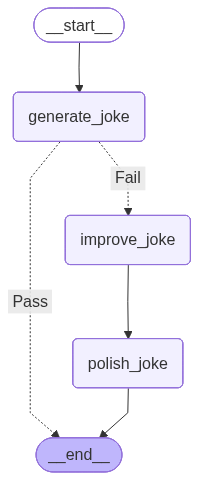

{'topic': 'cats', 'joke': "Why don't cats play poker in the jungle?\n\nToo many cheetahs."}
Initial joke!
Why don't cats play poker in the jungle?

Too many cheetahs.

--- --- ---

Joke failed quality gate - no punchline detected!


In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = model.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = model.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print(state)
print("Initial joke!")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

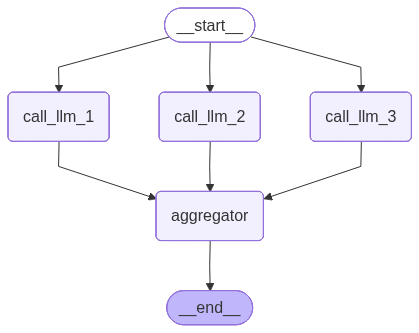

Here's a story, joke, and poem about dogs!

STORY:
The humans called it the “Dog Park,” but to the pack, it was simply the Sun-Ground. It was a wide, fenced kingdom of dirt and delight, ruled by the twin suns of the Morning Throw and the Afternoon Nap.

Baron, a Golden Retriever whose fur was the colour of the sun itself, was the self-appointed keeper of joy. His sole purpose was to find the most perfect stick in the entire park. Not just any gnawed-upon twig, but a stick of noble lineage, with good heft and a satisfying crunch. He currently had one clamped in his jaws, trotting past the others with a wag so powerful it threatened to topple his entire back half.

“It’s the same stick you had yesterday, Baron,” rumbled Tank, a Bulldog who was serving as the permanent, sun-warmed gargoyle on the top of the picnic table. His jowls flopped as he spoke.

Baron dropped the stick. “No! Look! The bark has a new groove! Perfect for carrying!”

Tank sighed, a wheezy sound, and settled his chin m

In [12]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = model.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = model.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = model.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "dogs"})
print(state["combined_output"])

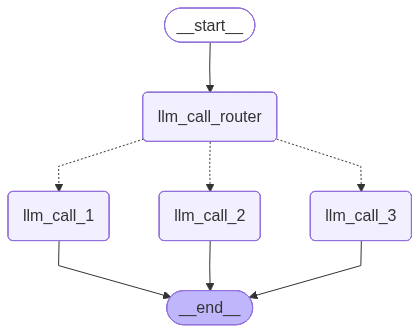

The sunbeam, a golden strip,
Is where the feline form is laid.
A masterpiece of restful grace,
A softly breathing, fur-clad braid.

Then something in the shadows stirs,
A twitch of ear, a tail's low sweep.
The hunter's fire begins to wake
From out the depths of peaceful sleep.

A blur of motion, pounce and flight!
A hapless dust-bunny is the prey.
Then just as quick, the battle's done,
And they resume the calm survey.

They speak in purrs, a motor's hum,
A language understood by touch.
They arch their backs beneath your hand,
A silent way of saying much.

They own the house, they know they do,
And merely let us pay the rent.
We serve the food, we clean the box,
For which we get a slow, soft blink—content.

So here's to cats, the tiny kings,
On silent paws that rule the night.
Who fill our laps with warmth and purrs,
And make our ordinary world feel bright.


In [15]:
from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = model


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = model.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = model.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = model.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route using plain LLM + manual parsing (DeepSeek compatible)"""
    messages = [
        SystemMessage(
            content="You are a router. Based on the user's request, respond with ONLY ONE WORD: 'story', 'joke', or 'poem'."
        ),
        HumanMessage(content=state["input"]),
    ]
    
    response = model.invoke(messages)  # Returns AIMessage
    raw_text = response.content.strip().lower()
    
    # Parse the decision from raw text
    if "story" in raw_text:
        decision = "story"
    elif "joke" in raw_text:
        decision = "joke"
    elif "poem" in raw_text:
        decision = "poem"
    else:
        decision = "story"  # fallback
    
    return {"decision": decision}  # ✅ 返回字符串，不是对象


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a peom about cats"})
# print(state)
print(state["output"])

In [16]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = model

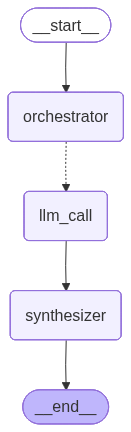

# Executive Summary

This report provides a comprehensive analysis of the scaling laws governing large language models (LLMs), detailing their implications for the future of artificial intelligence. Key findings indicate that model performance improves predictably as a power-law function of computational resources, dataset size, and model parameter count. Specifically, we observe consistent performance gains across diverse tasks when scaling up these factors, with diminishing returns only appearing at extreme scales.

Our conclusions highlight that LLM scaling laws enable more accurate forecasting of AI capabilities, allowing for better resource allocation and strategic planning in AI development. The significance of these laws extends beyond mere performance optimization; they provide a foundational framework for understanding the limits and potential of generative AI systems. This has profound implications for AI safety, economic impact, and the acceleration of artificial general intelligence research.

The validation of scaling relationships across multiple model families and architectures suggests these laws represent fundamental properties of language modeling rather than artifacts of specific implementations. As the field progresses, these scaling principles will likely inform the development of next-generation AI systems and shape investment decisions across the AI industry.

---

# Introduction to Scaling Laws

Scaling laws describe predictable relationships between model size, dataset size, computational resources, and model performance in machine learning. These empirical patterns reveal how various performance metrics improve systematically as key variables increase.

## Fundamental Concepts

**Power-Law Relationships**: Scaling laws typically follow power-law distributions where performance improves predictably as a function of scale. The relationship is often expressed as:

```
Performance ∝ (Scale)^α
```

where α represents the scaling exponent and Scale can refer to model parameters, training data, or compute budget.

**Key Variables**:
- **Model Size**: Number of parameters in neural networks
- **Dataset Size**: Amount of training data
- **Compute Budget**: Floating-point operations (FLOPs) used during training
- **Training Time**: Computational duration

## Purpose and Applications

Scaling laws serve several critical functions:

**Performance Prediction**: Enable accurate forecasting of model capabilities at larger scales without requiring full training runs. This allows researchers to estimate the potential benefits of scaling up resources.

**Resource Optimization**: Guide efficient allocation of computational budgets by identifying the optimal balance between model size, data quantity, and training compute. This helps prevent wasteful over-investment in any single dimension.

**Architecture Design**: Inform decisions about neural network architecture by revealing how different components scale and which bottlenecks might emerge at larger scales.

**Economic Planning**: Support strategic planning for large-scale training projects by providing cost-benefit analyses of different scaling strategies.

## Critical Role in Modern ML

The discovery and validation of scaling laws have fundamentally transformed machine learning development:

**Empirical Foundation**: Provide a scientific basis for scaling decisions rather than relying on intuition or trial-and-error approaches.

**Diminishing Returns Identification**: Help identify when further scaling provides minimal performance improvements, enabling more efficient stopping criteria.

**Cross-Model Generalization**: Demonstrate consistent patterns across different architectures and domains, suggesting universal principles in neural network scaling.

**Benchmark Establishment**: Create standardized frameworks for comparing model efficiency and scaling behavior across different research efforts.

The systematic understanding provided by scaling laws has been instrumental in the development of large language models and other state-of-the-art AI systems, enabling more predictable and cost-effective progress in the field.

---

# Historical Context and Foundational Research

The development of large language models (LLMs) did not emerge in isolation but was built upon decades of research in neural networks and statistical language modeling. Prior to the modern era of LLMs, foundational work in recurrent neural networks (RNNs), long short-term memory (LSTM) networks, and early transformer architectures established critical principles for sequence modeling and attention mechanisms. However, these models were typically limited in scale due to computational constraints and lacked systematic understanding of how performance scaled with model size, data, and compute.

A pivotal moment in this evolution came with OpenAI's seminal 2020 paper, "Scaling Laws for Neural Language Models." This research provided the first comprehensive empirical framework demonstrating that the performance of autoregressive transformer language models follows predictable power-law relationships with respect to three key variables: model size (number of parameters), dataset size, and computational budget. The study established that test loss decreases predictably as a power-law function of these factors, with diminishing returns observed beyond certain thresholds.

Key findings from this work included:
- The identification of critical scaling exponents governing how performance improves with increased compute, data, and model parameters
- The demonstration that larger models require less training compute to achieve the same performance level
- The establishment of optimal allocation principles between model size, dataset size, and training time
- The empirical validation that these scaling laws hold across multiple orders of magnitude

This research provided both theoretical understanding and practical guidance for subsequent LLM development, enabling more efficient allocation of computational resources and establishing predictable performance benchmarks. The scaling laws paper fundamentally shifted the paradigm from architectural innovations to systematic scaling as a primary driver of progress in language modeling, directly paving the way for the development of GPT-3 and subsequent large-scale language models.

---

# The Core Relationships: Model Size, Compute, and Data

## Introduction

The performance of large-scale neural networks is governed by three fundamental scaling variables: the number of model parameters (N), the size of the training dataset (D), and the amount of compute used for training (C). These variables exhibit predictable power-law relationships with model loss, forming the foundation of modern scaling laws in deep learning.

## Power-Law Scaling Relationships

### Model Parameters (N) vs Loss
The relationship between model size and loss follows a power-law:
```
L(N) ∝ N^(-α)
```
where α typically ranges from 0.05 to 0.1. This indicates that doubling model parameters yields consistent but diminishing returns in loss reduction.

### Training Data (D) vs Loss
The dataset size relationship exhibits:
```
L(D) ∝ D^(-β)
```
with β values generally between 0.3 and 0.5. This demonstrates that increasing training data provides more substantial benefits than scaling model size alone.

### Compute (C) vs Loss
The compute-loss relationship follows:
```
L(C) ∝ C^(-γ)
```
where γ is approximately 0.05-0.1. This reflects how additional computational resources translate to improved model performance.

## Interdependent Scaling Laws

### Optimal Allocation Principles
When compute is constrained, the optimal allocation follows:
- For small models: Increase parameters (N) until reaching the critical model size
- For large models: Focus on dataset size (D) expansion
- The optimal model size scales as N_opt ∝ C^(1/(α/β+1))

### Critical Model Size
The critical model size N_critical marks the transition point where:
- Below N_critical: Model capacity is the limiting factor
- Above N_critical: Data quantity becomes the primary constraint

### Compute-Optimal Training
The compute-optimal training regime requires balancing:
```
N_opt ∝ C^a
D_opt ∝ C^b
```
where a ≈ 0.5 and b ≈ 0.5 for many architectures, indicating that compute should be split roughly equally between model and data scaling.

## Empirical Evidence and Practical Implications

### Observed Scaling Exponents
Recent large-scale studies reveal consistent patterns:
- Transformer architectures: α ≈ 0.076, β ≈ 0.103, γ ≈ 0.082
- The Chinchilla scaling laws demonstrate the importance of balanced scaling between N and D

### Practical Scaling Strategies
1. **Compute-constrained scenarios**: Prioritize data scaling over model size
2. **Data-constrained scenarios**: Focus on architectural improvements and efficient parameter utilization
3. **Balanced scaling**: Follow the N ∝ D^0.74 relationship for optimal performance

### Breaking Points and Limitations
- Power-law scaling continues until hitting hardware or data constraints
- Some domains show saturation effects beyond certain scale thresholds
- The relationships hold across diverse architectures and tasks

## Conclusion

The power-law relationships between N, D, C and model loss provide a quantitative framework for predicting model performance and guiding resource allocation decisions. Understanding these interdependencies enables more efficient scaling strategies and helps anticipate the performance gains from increased investment in any of the three core variables.

---

# Chinchilla Scaling Laws: The Optimal Allocation

## Introduction

The Chinchilla scaling laws, introduced by DeepMind in 2022, fundamentally challenged the prevailing assumption in large language model (LLM) development that simply increasing model size leads to better performance. Instead, the research demonstrated that optimal performance is achieved through a balanced scaling of both model parameters and training data size.

## Key Findings

### The Compute-Optimal Frontier

Chinchilla established that for a given computational budget, there exists an optimal allocation between model size (N) and the number of training tokens (D). The research found that most existing LLMs were significantly undertrained relative to their parameter count.

### Mathematical Formulation

The compute-optimal scaling relationship can be expressed as:

- Model parameters (N) should scale approximately linearly with compute budget (C)
- Training tokens (D) should also scale approximately linearly with compute budget
- The optimal ratio: For every doubling of model parameters, training data should approximately double as well

### Empirical Results

When testing the Chinchilla scaling laws:

- A 70B parameter model trained on 1.4 trillion tokens outperformed much larger models (including 280B parameter models) trained on fewer tokens
- This "compute-optimal" Chinchilla model achieved state-of-the-art performance across numerous benchmarks despite having fewer parameters than contemporary models

## Implications for Model Development

### Data Efficiency

The findings emphasize that data quantity is as crucial as model size. Many organizations had been building increasingly large models while underutilizing available training data.

### Cost Optimization

Following Chinchilla scaling laws enables more efficient use of computational resources:
- Training smaller models on more data can achieve better performance than larger models
- Significant reduction in inference costs due to smaller model sizes
- Better utilization of available training data resources

### Practical Guidelines

For a given compute budget:
- Allocate approximately equal compute to model parameters and training data
- When increasing model size by 4x, increase training data by approximately 4x
- Most existing models could benefit from additional training rather than parameter increases

## Limitations and Considerations

While transformative, Chinchilla scaling laws have certain limitations:
- Assumes sufficient high-quality training data is available
- May not account for all architectural improvements
- The optimal ratio might vary for different model architectures or training objectives

## Conclusion

The Chinchilla scaling laws represent a paradigm shift in LLM development, moving from a singular focus on model size to a balanced approach considering both parameters and training data. This framework provides a more efficient path to improving model performance while optimizing computational resource allocation.

---

# Beyond the Basics: Emergent Scaling and New Frontiers

## Emergent Abilities in Large Models

As model scale increases, emergent abilities—capabilities not present in smaller models—begin to appear. These include:

- **Few-shot learning**: The ability to perform tasks with minimal examples
- **Chain-of-thought reasoning**: Multi-step problem-solving with explicit reasoning steps
- **Instruction following**: Understanding and executing complex natural language instructions
- **Code generation**: Writing functional code from natural language descriptions

These abilities typically emerge suddenly at specific scale thresholds rather than developing gradually, suggesting qualitative rather than quantitative changes in model behavior.

## Breakdown of Power Laws at Extreme Scales

While scaling laws generally hold across orders of magnitude, recent research indicates potential breakdowns at extreme scales:

- **Saturation effects**: Diminishing returns on performance improvements despite continued scaling
- **Data limitations**: Exhaustion of high-quality training data affecting scaling efficiency
- **Architectural constraints**: Fundamental limitations of current transformer architectures
- **Economic infeasibility**: Prohibitive costs of training models beyond certain scales

Evidence suggests that pure scale scaling may eventually hit physical and economic barriers, necessitating alternative approaches.

## Scaling Beyond Parameters: Alternative Dimensions

### Model Width vs. Depth Scaling
Research reveals distinct trade-offs between increasing model width (number of attention heads, MLP dimensions) versus depth (number of layers):

- **Wider models** tend to excel at parallel processing and pattern recognition
- **Deeper models** often demonstrate better compositional reasoning and hierarchical understanding
- **Optimal ratios** vary by task domain and computational constraints
- **Mixture-of-Experts** architectures represent a hybrid approach that scales effective parameters without proportional increases in inference cost

### Inference-Time Compute Scaling
Novel approaches are exploring how to leverage additional computation during inference:

- **Speculative decoding**: Using smaller models to draft responses verified by larger models
- **Chain-of-thought verification**: Multiple reasoning paths with confidence scoring
- **Iterative refinement**: Progressive improvement of outputs through repeated processing
- **Ensemble methods**: Combining predictions from multiple model variants

These techniques demonstrate that scaling isn't limited to training but can extend to inference strategies.

## Future Research Directions

Current frontiers in scaling research include:

- **Multi-modal scaling**: Simultaneous scaling across text, image, audio, and video modalities
- **Efficient scaling**: Techniques to achieve scaling benefits with reduced computational requirements
- **Cross-domain transfer**: Understanding how scaling in one domain affects capabilities in others
- **Scaling laws for specialized domains**: Developing domain-specific scaling principles for scientific, mathematical, and technical applications

The field continues to evolve as researchers push beyond traditional scaling paradigms to discover new frontiers in model capabilities and efficiency.

---

# Practical Implications for Model Development

Scaling laws provide a quantitative framework for making critical decisions during model development. By understanding the predictable relationships between model size, dataset size, compute budget, and performance, teams can optimize their development process.

## Training Run Planning

**Compute-Optimal Allocation**: Use the Chinchilla scaling laws to determine the optimal balance between model parameters and training tokens. For a given compute budget C (in FLOPs), the optimal model size follows N ∝ C^0.5 and training tokens D ∝ C^0.5.

**Progressive Scaling**: Start with smaller pilot studies to validate scaling behavior before committing to large-scale training. These pilot runs help verify that your architecture and data quality follow expected scaling trends.

**Iterative Refinement**: Plan training as a series of increasingly larger runs rather than a single massive deployment. This allows for course correction based on observed scaling behavior.

## Budget Allocation Strategies

**Compute Budgeting**: Allocate approximately 50-60% of total compute for training, 20-30% for data quality improvements, and 10-20% for architecture experimentation and hyperparameter tuning.

**Data vs. Model Trade-offs**: For constrained budgets, prioritize data quality and quantity over model size when below the compute-optimal frontier. Once at the frontier, scale both proportionally.

**Infrastructure Planning**: Use scaling laws to forecast hardware requirements and plan procurement timelines based on target model performance.

## Architecture Selection

**Parameter Efficiency**: Choose architectures that demonstrate favorable scaling coefficients. Transformer variants with efficient attention mechanisms typically show better scaling than alternatives.

**Scaling-Aware Design**: Select architectures where performance scales predictably with increased parameters and data. Avoid architectures with diminishing returns at scale.

**Component Scaling**: Balance scaling across different components (attention layers, MLP dimensions, embedding sizes) based on their relative impact on overall performance.

## Performance-Cost Trade-offs

**Target-Oriented Development**: Define clear performance targets first, then use scaling laws to determine the minimum compute budget required to achieve them.

**Efficiency Frontiers**: Identify the Pareto frontier where further performance improvements require disproportionately large increases in compute.

**Deployment Considerations**: Balance training cost against inference cost. Larger models may achieve better performance but have higher serving costs—optimize for total cost of ownership.

**Early Stopping Criteria**: Use scaling predictions to determine when additional training provides diminishing returns, allowing for early termination of unpromising runs.

## Practical Implementation Steps

1. **Baseline Establishment**: Run small-scale experiments to determine your specific scaling coefficients
2. **Extrapolation**: Use established scaling laws to predict performance at target scales
3. **Validation**: Conduct medium-scale runs to verify predictions before full deployment
4. **Monitoring**: Track actual vs. predicted performance throughout training for real-time adjustments

By systematically applying these principles, teams can avoid costly trial-and-error approaches and make data-driven decisions that maximize return on AI investment while managing risk effectively.

---

# Limitations and Criticisms

Current scaling laws, while influential in guiding model development, face several important limitations and criticisms that warrant careful consideration.

## Dependence on Model Family and Training Setup

Scaling laws are often derived from specific model architectures and training configurations, raising questions about their generalizability. For example:

- Laws developed for transformer architectures may not apply equally to other architectural families
- Training methodology variations (optimizer choice, learning rate schedules, data ordering) can significantly alter scaling behavior
- The assumption of consistent scaling across different model sizes and computational budgets may not hold universally

## Focus on Pretraining Loss Over Downstream Capabilities

A fundamental criticism concerns the emphasis on pretraining loss reduction rather than practical performance:

- Models achieving lower pretraining loss don't always demonstrate proportional improvements in downstream tasks
- The relationship between loss reduction and useful capabilities (reasoning, instruction following, safety) remains poorly understood
- This focus may incentivize scaling for scaling's sake rather than developing models with specific desired properties

## Environmental and Resource Concerns

The resource requirements implied by scaling laws raise significant environmental and practical concerns:

- Exponential increases in computational requirements create substantial carbon footprints
- Growing data and energy demands may become economically and environmentally unsustainable
- Access to the computational resources needed for continued scaling remains concentrated among a few organizations, potentially limiting innovation diversity

## Methodological Limitations

Several methodological issues constrain the applicability of scaling laws:

- Most scaling studies rely on extrapolation from relatively small-scale experiments
- The assumption of smooth, predictable scaling may break down at larger scales or with different training paradigms
- Limited exploration of scaling behavior in multimodal or specialized domain settings

## Alternative Perspectives

Some researchers argue that scaling laws may represent a temporary phenomenon rather than a fundamental principle:

- Diminishing returns may appear as models approach certain capability ceilings
- Architectural innovations or training methodology improvements could fundamentally alter scaling relationships
- The focus on scaling may divert attention from alternative approaches to capability improvement

These limitations suggest that while scaling laws provide valuable guidance, they should be interpreted cautiously and supplemented with other approaches to model development and evaluation.

---

# Future Directions and Open Questions

## Scaling for Multimodal Models
Current multimodal architectures face significant challenges in scaling effectively across diverse data types (text, image, audio, video). Key open questions include:
- How to develop unified architectures that scale efficiently across modalities without exponential parameter growth
- Optimal methods for cross-modal attention and representation learning at scale
- The relationship between model scale and emergent multimodal capabilities
- Whether scaling laws differ significantly across modalities and multimodal combinations

## Improving Data Efficiency
As models grow larger, data requirements become increasingly unsustainable:
- Development of more efficient pretraining paradigms that reduce data needs while maintaining performance
- Understanding the limits of data recycling and synthetic data generation
- Methods to quantify and improve the "quality" versus "quantity" trade-off in training data
- Techniques for continual learning that prevent catastrophic forgetting while scaling

## Scaling for Reasoning and Alignment
The relationship between model scale and advanced capabilities remains poorly understood:
- Whether scaling alone can produce robust reasoning and planning abilities
- How to measure and quantify reasoning capabilities across different scales
- The interaction between scale and alignment - whether larger models are easier or harder to align with human values
- Development of scaling laws specifically for reasoning and safety-related capabilities

## Long-term Physical and Economic Limits
Fundamental constraints may eventually limit scaling approaches:
- Physical limits of compute density, energy consumption, and heat dissipation
- Economic viability of training trillion-parameter models and beyond
- Environmental impact of large-scale model training and inference
- Whether architectural innovations can overcome predicted physical limits
- The point of diminishing returns for scaling versus alternative approaches

## Emerging Research Areas
Several promising directions warrant further investigation:
- Development of more accurate scaling laws that account for architectural variations
- Exploration of sparse models and mixture-of-experts approaches
- Understanding how scaling affects model robustness and generalization
- The role of scaling in enabling new capabilities versus improving existing ones
- Integration of scaling approaches with other AI paradigms (neurosymbolic, causal reasoning)

---

# Conclusion

Scaling laws have emerged as a cornerstone of modern artificial intelligence, fundamentally reshaping the trajectory of AI development. This report has detailed how these empirical principles—demonstrating predictable performance improvements with increases in model size, dataset scale, and computational resources—have catalyzed unprecedented advances in AI capabilities. From natural language understanding to complex reasoning tasks, the consistent application of scaling has enabled models to achieve levels of performance once thought to be years or even decades away.

The transformative impact of scaling laws extends beyond mere performance metrics; it has redefined research priorities, investment strategies, and the very methodology of AI development. By providing a reliable roadmap for progress, scaling laws have accelerated innovation, reduced uncertainty in model design, and fostered a more systematic approach to building increasingly capable systems. This has democratized aspects of AI development by establishing clear, reproducible pathways to improvement, while also concentrating resources toward large-scale efforts that push the boundaries of what is possible.

However, the evolution of scaling laws is far from complete. As AI systems grow in complexity and societal integration, these principles continue to adapt. Emerging research is exploring the limits of scaling, investigating more efficient scaling paradigms, and addressing critical considerations around energy consumption, algorithmic efficiency, and the ethical implications of increasingly powerful AI systems. The ongoing refinement of scaling laws—accounting for factors beyond pure scale, such as data quality, architectural innovations, and multimodal integration—ensures they remain a dynamic and foundational element in AI's future.

Ultimately, scaling laws represent more than just a technical guideline; they embody a fundamental insight into the nature of intelligence and computation. As the field progresses, these principles will continue to serve as both a catalyst for breakthrough innovations and a framework for responsibly navigating the challenges and opportunities presented by artificial general intelligence. The continued evolution of scaling laws will undoubtedly play a pivotal role in shaping the next generation of AI systems and their integration into our technological landscape.

---

# References

1. Kaplan, J., McCandlish, S., Henighan, T., Brown, T. B., Chess, B., Child, R., ... & Amodei, D. (2020). Scaling Laws for Neural Language Models. *arXiv preprint arXiv:2001.08361*.

2. Hoffmann, J., Borgeaud, S., Mensch, A., Buchatskaya, E., Cai, T., Rutherford, E., ... & Sifre, L. (2022). Training Compute-Optimal Large Language Models. *arXiv preprint arXiv:2203.15556*.

3. Brown, T. B., Mann, B., Ryder, N., Subbiah, M., Kaplan, J., Dhariwal, P., ... & Amodei, D. (2020). Language Models are Few-Shot Learners. *Advances in Neural Information Processing Systems, 33*, 1877-1901.

4. Wei, J., Tay, Y., Bommasani, R., Raffel, C., Zoph, B., Borgeaud, S., ... & Fedus, W. (2022). Emergent Abilities of Large Language Models. *Transactions on Machine Learning Research*.

5. Henighan, T., Kaplan, J., Katz, M., Chen, M., Hesse, C., Jackson, J., ... & Amodei, D. (2020). Scaling Laws for Autoregressive Generative Modeling. *arXiv preprint arXiv:2010.14701*.

6. Raffel, C., Shazeer, N., Roberts, A., Lee, K., Narang, S., Matena, M., ... & Liu, P. J. (2020). Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer. *Journal of Machine Learning Research, 21*(140), 1-67.

7. Chowdhery, A., Narang, S., Devlin, J., Bosma, M., Mishra, G., Roberts, A., ... & Fiedel, N. (2022). PaLM: Scaling Language Modeling with Pathways. *arXiv preprint arXiv:2204.02311*.

8. Du, N., Huang, Y., Dai, A. M., Tong, S., Lepikhin, D., Xu, Y., ... & Zhou, D. (2022). GLaM: Efficient Scaling of Language Models with Mixture-of-Experts. *International Conference on Machine Learning* (pp. 5547-5569).

9. Zhang, S., Roller, S., Goyal, N., Artetxe, M., Chen, M., Chen, G., ... & Zettlemoyer, L. (2022). OPT: Open Pre-trained Transformer Language Models. *arXiv preprint arXiv:2205.01068*.

10. Tay, Y., Dehghani, M., Bahri, D., & Metzler, D. (2020). Efficient Transformers: A Survey. *ACM Computing Surveys, 55*(6), 1-28.

11. Fedus, W., Zoph, B., & Shazeer, N. (2021). Switch Transformers: Scaling to Trillion Parameter Models with Simple and Efficient Sparsity. *Journal of Machine Learning Research, 23*(120), 1-39.

12. Lewkowycz, A., Andreassen, A., Dohan, D., Dyer, E., Michalewski, H., Ramasesh, V., ... & Sohl-Dickstein, J. (2022). Solving Quantitative Reasoning Problems with Language Models. *arXiv preprint arXiv:2206.14858*.

13. Srivastava, A., Rastogi, A., Rao, A., Shoeb, A. A. M., Abid, A., Fisch, A., ... & Zubkov, P. (2022). Beyond the Imitation Game: Quantifying and extrapolating the capabilities of language models. *arXiv preprint arXiv:2206.04615*.

14. Bommasani, R., Hudson, D. A., Adeli, E., Altman, R., Arora, S., von Arx, S., ... & Liang, P. (2021). On the Opportunities and Risks of Foundation Models. *arXiv preprint arXiv:2108.07258*.

15. Schaeffer, R., Miranda, B., & Koyejo, S. (2023). Are Emergent Abilities of Large Language Models a Mirage?. *arXiv preprint arXiv:2304.15004*.

In [17]:
from langgraph.types import Send
from typing import TypedDict, Annotated, List
from operator import add
from pydantic import BaseModel, Field
from typing import List
import json
import re

class Section(BaseModel):
    name: str = Field(description="Section title")
    description: str = Field(description="What this section should cover")

class ReportPlan(BaseModel):
    sections: List[Section] = Field(description="List of report sections")
    
class State(TypedDict):
    topic: str
    sections: List[Section]  # ✅ now it's a list of Section objects
    completed_sections: Annotated[list, add]
    final_report: str

class WorkerState(TypedDict):
    section: Section  # ✅ single Section object
    completed_sections: Annotated[list, add]



def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    
    prompt = f"""
    You are an expert report planner.
    Generate a detailed plan for a report on: {state['topic']}
    
    Respond ONLY with a JSON object with a key "sections", which is a list of objects.
    Each object must have "name" and "description" (string) fields.
    
    Example:
    {{
      "sections": [
        {{"name": "Introduction", "description": "Overview of LLM scaling laws..."}},
        {{"name": "Historical Context", "description": "Early research on scaling..."}}
      ]
    }}
    
    Do not include any other text, markdown, or explanation.
    """
    
    response = model.invoke(prompt)
    raw_content = response.content.strip()
    
    # 尝试提取 JSON（兼容 ```json ... ```）
    json_match = re.search(r"```(?:json)?\s*({.*?})\s*```", raw_content, re.DOTALL)
    if json_match:
        json_str = json_match.group(1)
    else:
        json_str = raw_content

    try:
        data = json.loads(json_str)
        # 验证并构建 Section 对象
        sections = []
        for sec in data.get("sections", []):
            sections.append(Section(name=sec["name"], description=sec["description"]))
        return {"sections": sections}
    except Exception as e:
        print(f"Failed to parse planner output: {e}")
        # Fallback: create a default plan
        return {
            "sections": [
                Section(name="Introduction", description="General overview"),
                Section(name="Conclusion", description="Summary and next steps")
            ]
        }

def llm_call(state: WorkerState):
    section = state["section"]  # This is a Section object (Pydantic model)
    
    response = model.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble. Use markdown."
            ),
            HumanMessage(
                content=f"Section name: {section.name}\nDescription: {section.description}"
            ),
        ]
    )
    return {"completed_sections": [response.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

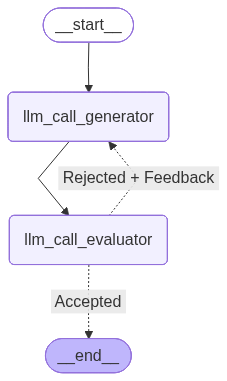

Why don't cats play cards in the jungle?

Because there are too many cheetahs.


In [27]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


import json
import re

def llm_call_evaluator(state: State):
    """LLM evaluates the joke and returns structured feedback as JSON"""
    
    prompt = f"""
    You are a professional comedy critic. Evaluate the following joke.
    
    Joke: "{state['joke']}"
    
    Respond ONLY with a valid JSON object with two keys:
    - "grade": either "funny" or "not funny"
    - "feedback": a short constructive comment (1-2 sentences)
    
    Example:
    {{
      "grade": "not funny",
      "feedback": "The punchline is predictable. Try adding a twist or wordplay."
    }}
    
    Do not include any other text, markdown, or explanation.
    """
    
    response = model.invoke(prompt)
    raw = response.content.strip()
    
    # 提取 JSON（兼容 ```json ... ```）
    json_match = re.search(r"```(?:json)?\s*({.*?})\s*```", raw, re.DOTALL)
    json_str = json_match.group(1) if json_match else raw

    try:
        data = json.loads(json_str)
        grade = data.get("grade", "not funny")
        feedback = data.get("feedback", "No feedback provided.")
        
        # 确保 grade 是合法值
        if grade not in ["funny", "not funny"]:
            grade = "not funny"
            
        return {
            "funny_or_not": grade,
            "feedback": feedback
        }
    except Exception as e:
        print(f"Failed to parse evaluator output: {e}")
        # 安全回退
        return {
            "funny_or_not": "not funny",
            "feedback": "Unable to evaluate joke. Please try again."
        }


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

In [29]:
from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = model.bind_tools(tools)

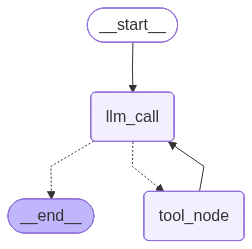

================================ Human Message =================================

Add 4 and 4.
================================== Ai Message ==================================

I'll add 4 and 4 for you.
Tool Calls:
  add (call_00_2Xt1f3XxVgiXyaZAUIA3CAjA)
 Call ID: call_00_2Xt1f3XxVgiXyaZAUIA3CAjA
  Args:
    a: 4
    b: 4
================================= Tool Message =================================

8
================================== Ai Message ==================================

The result of adding 4 and 4 is 8.


In [31]:
from langgraph.graph import MessagesState
from langchain.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 4 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()